In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torch.utils.data
import torchvision.transforms.functional as F
import matplotlib as mpl

import transforms
import visualize

## Dataset setup

In [2]:
classnames = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'potted plant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tv/monitor'
}
CLASS_MAX=20

In [3]:
ds_train = torchvision.datasets.VOCSegmentation(
    root="./data/",
    year="2012",
    image_set="train",
    download=False,
    transform=transforms.input_transform(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD),
    target_transform=transforms.target_transform(max_class=transforms.PASCAL_VOC_2012_CLASS_MAX))
#ds_val = torchvision.datasets.VOCSegmentation(root="./data/", year="2012", image_set="val", download=download_ds, transform=transform, target_transform=target_transform)

In [4]:
# dataset returns normalized images, we need an inverse op for visualization
inv_normalize = transforms.inv_normalize(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

In [5]:
len(ds_train)

1464

In [6]:
img, mask = ds_train[2]

In [7]:
img.shape

torch.Size([3, 256, 256])

In [8]:
img.device

device(type='cpu')

In [9]:
mask.shape

torch.Size([256, 256])

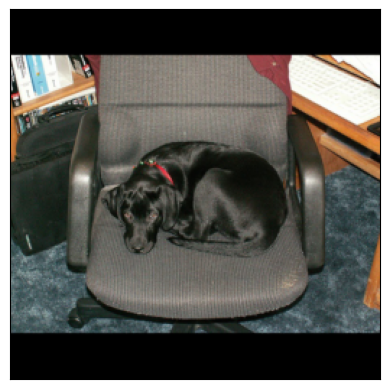

In [10]:
visualize.imshow_tensor(inv_normalize(img))

## Load Model

In [11]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=CLASS_MAX+1, init_features=32, pretrained=False)

Using cache found in /home/akors/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [13]:
model = torch.load("dogunet_home.pth")

## Predictions in dataset

In [14]:
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = pred.to(device='cpu')

In [15]:
pred_amax = torch.argmax(pred.squeeze(0), dim=0)

In [16]:
pred_amax.shape

torch.Size([256, 256])

In [17]:
mask.shape

torch.Size([256, 256])

In [18]:
comp = visualize.make_comparison_grid(img=img.unsqueeze(0), prediction=pred_amax.unsqueeze(0), mask=mask.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


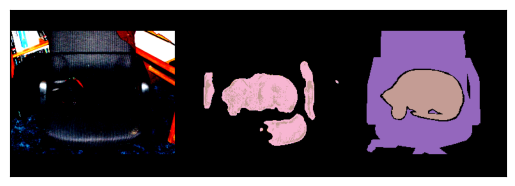

In [19]:
visualize.imshow_tensor(comp)

In [20]:
pred_classes, counts = pred_amax.unique(return_counts=True)

In [21]:
topcounts, topcounts_idx = torch.topk(counts, 3)

In [22]:
pred_classes[topcounts_idx]

tensor([ 0, 14, 12])

In [23]:
classpixels = {
    classnames[pred_classes[i].item()] : counts[i].item()
    for i in topcounts_idx
}

In [24]:
classpixels

{'background': 55594, 'motorbike': 8093, 'dog': 1765}

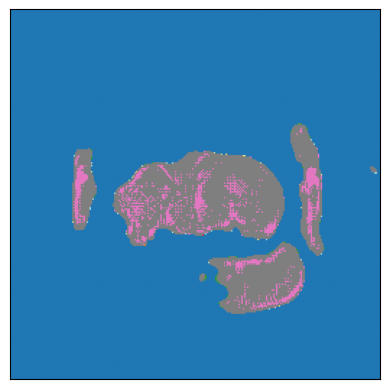

In [25]:
visualize.imshow_mask_tensor(pred_amax)

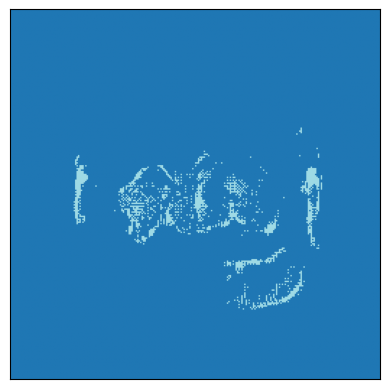

In [26]:
pred_img = (pred_amax == 12).to(dtype=torch.int8)
visualize.imshow_mask_tensor(pred_img)

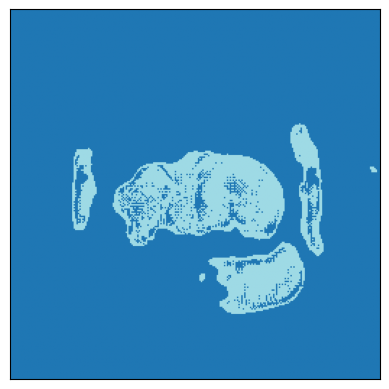

In [27]:
pred_img = (pred_amax == 14).to(dtype=torch.int8)
visualize.imshow_mask_tensor(pred_img)

In [28]:
mask = torch.where(mask <= CLASS_MAX, mask, 0).to(dtype=torch.long)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


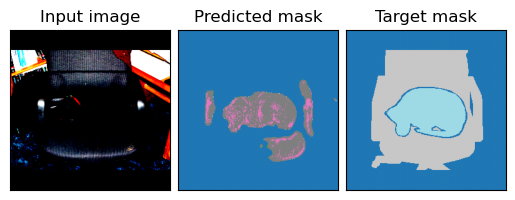

In [29]:
comp_fig = visualize.plot_prediction_comparison(img, pred_amax, mask.squeeze(0))